In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import fitsio
import sys, os, time, argparse, glob
import warnings; warnings.simplefilter('ignore')

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/BGS_paper/')
from main_def import get_sweep_patch, cut, cut_sweeps, get_random_patch
from geometric_def import query_catalog_mask, LSLGA_fit, LSLGA_veto, circular_mask_radii_func


# Geometric masking around bright sources

## SWEEP subsample lite

For this notebook we're going to use a small subsample catalogue of $\sim 200$ deg$^2$ and with r-mag limit of $20$.
    
$$180 < RA < 200$$
$$5 < DEC < 15$$

In [3]:
#define the square/rectangle patch of the sky in format [RAmin, RAmax, DECmin, DECmax]
main_patch = [180, 200, 5, 15]
#get subsample catalogue

rlimit = 20
N = 2
dr = 'dr7'
    
ramin, ramax, decmin, decmax = main_patch[0], main_patch[1], main_patch[2], main_patch[3]
dir_name = '%s_%s_%s_%s_%s_rmag_%s_N_%s' %(dr, str(ramin), str(ramax), str(decmin), 
                                                 str(decmax), str(20), str(N))
dir_ = os.path.isdir(dir_name)

if dir_:
    print('The directory with %i < RA < %i, %i < DEC < %i, rmag limit=%2.2g and N=%i already exist...' 
          %(ramin, ramax, decmin, decmax, rlimit, N))
else:
    os.system('mkdir %s' %(dir_name))

#get subsample catalogue
df = get_sweep_patch(patch=main_patch, rlimit=rlimit, dr=dr)

The directory with 180 < RA < 200, 5 < DEC < 15, rmag limit=20 and N=2 already exist...
sweep file already exist at:/global/project/projectdirs/desi/users/qmxp55/BGS_paper/dr7_sweep_180_200_5_15_rmag_20.npy
Total run time: 0.000177 sec
Area of 180 < RA < 200 & 5 < DEC < 15: 196.7 deg^2
Weight of dr7_sweep_180_200_5_15_rmag_20.npy catalogue: 454.78 MB


## Loading Tycho2 catalogue as Star catalogue

In [4]:
#Loading Tycho2 catalogue
path = '/global/homes/q/qmxp55/DESI/matches/'
tycho_ = fitsio.read(path+'tycho2.fits')
#cutting out to the same footprint as DECaLS catalogue
tycho = cut(main_patch[0], main_patch[1], main_patch[2], main_patch[3], tycho_)

## Loading LSLGA catalogue as Galaxy catalogue

In [5]:
#Loading the Legacy Survey Large Galaxy Atlas (href: https://github.com/moustakas/LSLGA)
LSLGA_ = fitsio.read('/global/project/projectdirs/desi/users/qmxp55/matches/LSLGA-v2.0.fits')
#cutting out to the same footprint as DECaLS catalogue
LSLGA = cut(main_patch[0], main_patch[1], main_patch[2], main_patch[3], LSLGA_)

In [6]:
!du -h /global/project/projectdirs/desi/users/qmxp55/matches/tycho2.fits

81M	/global/project/projectdirs/desi/users/qmxp55/matches/tycho2.fits


## Masking out around Bright Sources

### mag-radii functions for TYCHO stars and LSLGA galaxies

In [19]:
#Rongpu's circ radii
rongpuLRG_radii = [[4.0, 210.],[4.5, 210.], [5.5, 200.], [6.25, 150.], [6.75, 125.],
                   [7.25, 120.], [7.75, 110.], [8.25, 100.], [8.75,  75.], [9.25,  60.],
                   [9.75,  55.], [ 10.25,  50.], [ 10.75,  48.], [ 11.25,  40.], [ 11.75,  37.], 
                   [ 12.25,  25.], [ 12.75,  20.], [ 13.25,  18.], [ 13.75,  16.], [ 14.25,  12.], 
                   [ 14.75,  11.], [ 15.25,  11.], [ 15.75,  10.]]

#Rongpu's length radii (diff spikes)
rongpuLRG_length_radii = [[4.0, 600.], [4.5, 600.], [5.5, 600.], [6.25, 540.], [6.75, 520.], [7.25, 500.], 
                   [7.75, 320.], [8.25, 300.], [8.75, 290.], [9.25, 160.], [9.75, 150.], [ 10.25, 140.],
                   [ 10.75, 130.], [ 11.25, 130.], [ 11.75, 100.], [ 12.25, 60.], [ 12.75, 40.], [ 13., 40.]]

#Rongpu's widht radii (diff spikes)
rongpuLRG_widht_radii = [[8., 25.], [13., 16.]]

#kyle_radii's = rongpuLRG_radii's/np.sqrt(2)
kyle_radii = []
for i in range(len(rongpuLRG_radii)):
    kyle_radii.append([rongpuLRG_radii[i][0], rongpuLRG_radii[i][1]/np.sqrt(2)])

kyle_length_radii = []
for i in range(len(rongpuLRG_length_radii)):
    kyle_length_radii.append([rongpuLRG_length_radii[i][0], rongpuLRG_length_radii[i][1]/np.sqrt(2)])

kyle_widht_radii = []
for i in range(len(rongpuLRG_widht_radii)):
    kyle_widht_radii.append([rongpuLRG_widht_radii[i][0], rongpuLRG_widht_radii[i][1]/np.sqrt(2)])
    
#TWOMASS radii
twomass_radii = [[9.5,100], [10.5, 80], [11.5, 70], [12.5, 50], [13.5, 30], 
                 [14.5, 20], [15.5, 10], [16.5, 5]]

#LSLGA radii
LSLGA_radii = [[9.5,100], [10.5, 90], [11.5, 80], [12.5, 70], [13.5, 60], 
               [14.5, 50], [15.5, 35], [16.5, 25], [17.5, 15], [17.5, 10], [18, 8]]

#Dustin_radii's
mag = np.linspace(0, 20, 50)
Dustin_MS_radii = []
for i,j in enumerate(mag):
    Dustin_MS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])

In [20]:
x =np.linspace(0, 20, 30)
ty_rad = np.minimum(1800., 150. * 2.5**((11. - x)/3.)) * 0.262/1

In [25]:
def mask_funct(radii_1, radii_2, MAG, D25):
    
    fig = plt.figure(figsize=(10,4))
    
    mag = np.linspace(0, 20, 30)
    mag2 = np.linspace(0, 20, 30)
    ty_rad = np.minimum(1800., 150. * 2.5**((11. - mag)/3.)) * 0.262/1
    
    plt.plot(mag, circular_mask_radii_func(mag, radii_1, bestfit=False), marker='o', color='k', linestyle='-', label=r'Ronpu/$\sqrt{2}$ circ')
    plt.plot(mag, circular_mask_radii_func(mag, radii_1), marker='o', color='red', linestyle='--', label=r'best-fit')
    #plt.plot(mag, ty_rad, marker='o', color='b', linestyle='--', label=r'Dustin')
    plt.plot(mag, circular_mask_radii_func(mag, Dustin_MS_radii, bestfit=False), marker='o', color='green', linestyle='--', label=r'Dustin')
    
    plt.title(r'Mask radii for Brigh Stars')
    plt.legend()
    plt.grid()
    plt.xlabel(r'MAG_VT')
    plt.ylabel(r'r(arcsec)')
    
    plt.show()
    
    fig = plt.figure(figsize=(10,4))
    
    plt.plot(mag2, circular_mask_radii_func(mag2, radii_2, bestfit=False), marker='o', color='k', linestyle='-', label=r'LSLGA major-axis')
    plt.plot(mag2, circular_mask_radii_func(mag2, radii_2), marker='o', color='red', linestyle='--', label=r'best-fit')
    plt.scatter(MAG, D25*60, s=3, label=r'D25 (arcsec)')
    
    plt.title(r'Mask radii for LSLGA')
    plt.legend()
    plt.grid()
    plt.xlabel(r'MAG')
    plt.ylabel(r'r(arcsec)')
    
    plt.show()

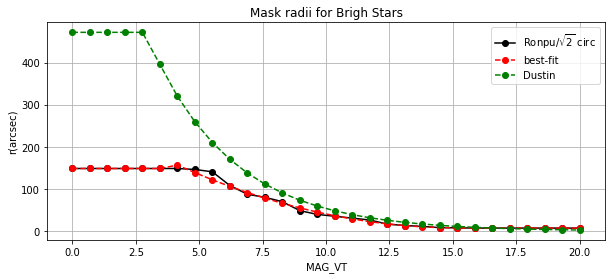

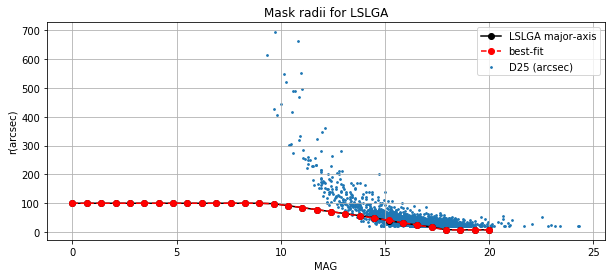

In [26]:
mask_funct(kyle_radii, LSLGA_radii, LSLGA['MAG'], LSLGA['D25'])

### Star mask

In [8]:
#tyFlag is BGS index flag for objects masked by tycho
tyFlag = query_catalog_mask(df['RA'], df['DEC'], tycho, kyle_radii, diff_spikes=True, 
                             length_radii=kyle_length_radii, widht_radii=kyle_widht_radii, 
                                return_diagnostics=False)

0.00 < MAG_VT < 0.50   10 TYCHO bright stars
390 nearby objects
217 objects masked by circular mask
8 additionally objects masked by diffraction spikes mask
225 objects masked by the combined masks

0.50 < MAG_VT < 1.00   0 TYCHO bright stars

1.00 < MAG_VT < 1.50   0 TYCHO bright stars

1.50 < MAG_VT < 2.00   0 TYCHO bright stars

2.00 < MAG_VT < 2.50   0 TYCHO bright stars

2.50 < MAG_VT < 3.00   1 TYCHO bright stars
807 nearby objects
628 objects masked by circular mask
10 additionally objects masked by diffraction spikes mask
638 objects masked by the combined masks

3.00 < MAG_VT < 3.50   0 TYCHO bright stars

3.50 < MAG_VT < 4.00   0 TYCHO bright stars

4.00 < MAG_VT < 4.50   1 TYCHO bright stars
323 nearby objects
254 objects masked by circular mask
2 additionally objects masked by diffraction spikes mask
256 objects masked by the combined masks

4.50 < MAG_VT < 5.00   3 TYCHO bright stars
768 nearby objects
440 objects masked by circular mask
14 additionally objects masked by d

### Galaxy mask

In [9]:
LSLGA_mask_cat = LSLGA_veto(df, LSLGA, LSLGA_radii, N=1)

Total run time: 412.970790 sec


pixels: 2476
LSLGA: RA = 193.07, DEC = 11.314, MAG=11.401, angle = 22


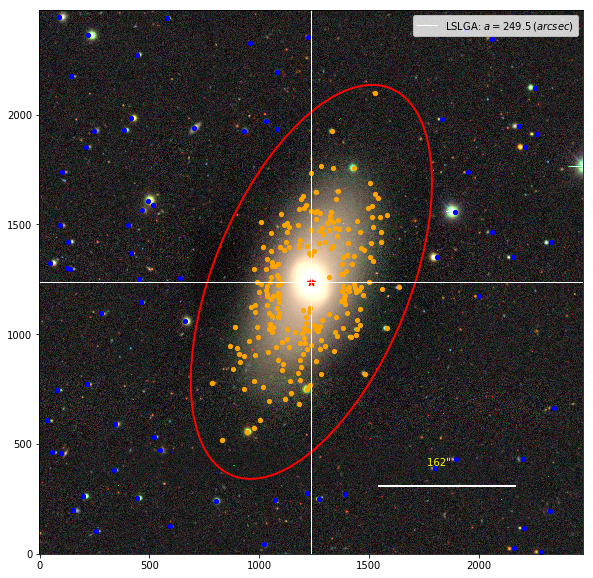

pixels: 1509
LSLGA: RA = 185.39, DEC = 14.606, MAG=11.943, angle = 136


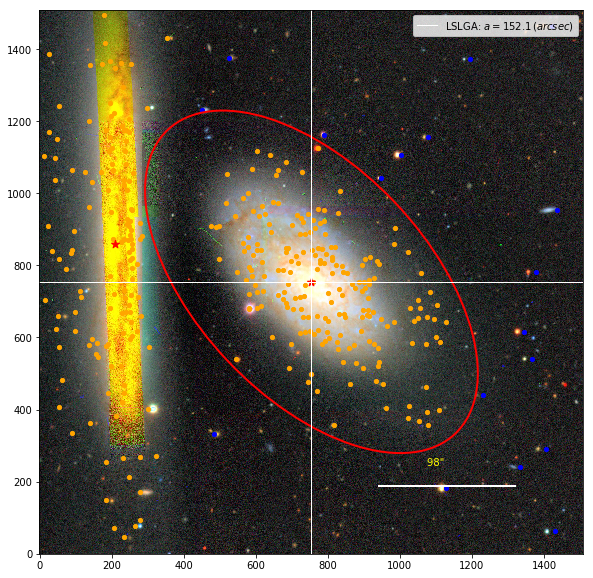

pixels: 1188
LSLGA: RA = 192.06, DEC = 10.983, MAG=12.211, angle = 134


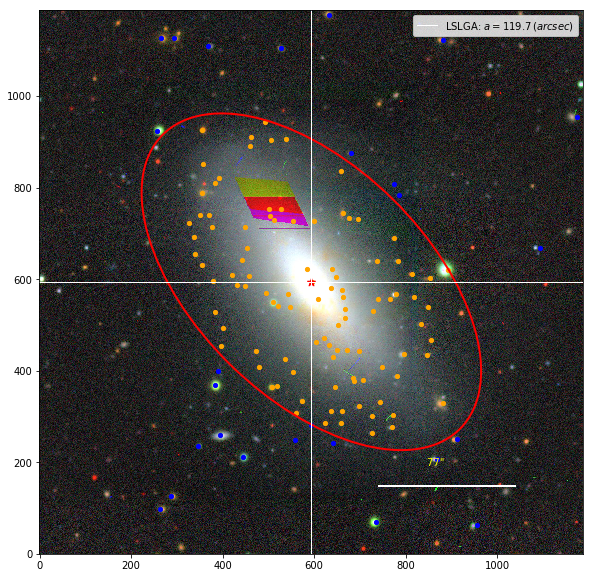

pixels: 1468
LSLGA: RA = 190.24, DEC = 11.912, MAG=12.63, angle = 14


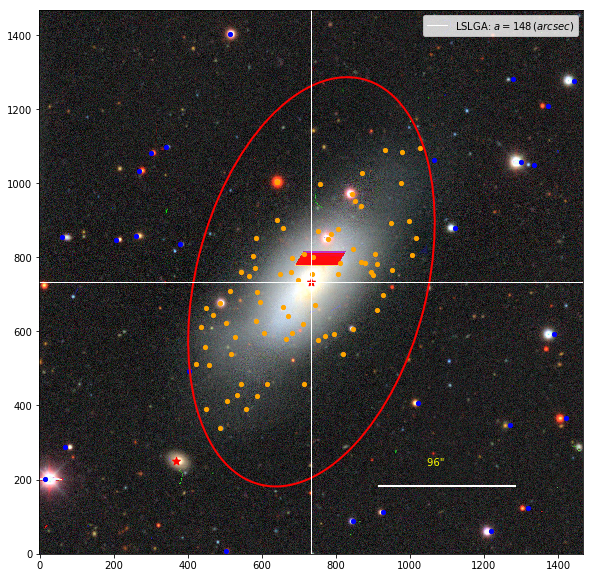

pixels: 997
LSLGA: RA = 188.17, DEC = 14.051, MAG=13.306, angle = 27


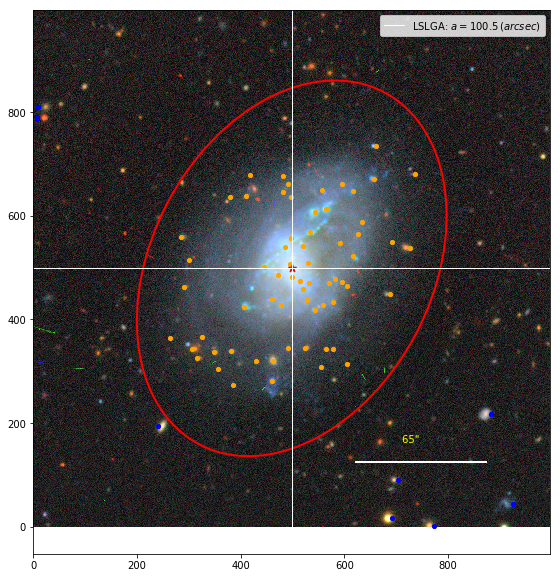

In [72]:
RAi = [193.0728855, 185.3867325, 192.0628695, 190.239663, 188.174391]
DECi = [11.3139405, 14.6060549, 10.9834901, 11.911689, 14.0505168]

for i in range(len(RAi)):
    plot_ellipse_img(coord=[df['RA'], df['DEC']], LG=LSLGA, LG_radii=None, N=1, LGname='LSLGA', 
             veto=LSLGA_mask_cat, scale=0.262, scale_unit='pixscale', layer='decals-dr7',
             ra=RAi[i], dec=DECi[i], m=1.3)


In [71]:
mask = (LSLGA['MAG'] > 13) & (LSLGA['MAG'] < 13.5)
for i in range(5):
    print(LSLGA['RA'][mask][i], LSLGA['DEC'][mask][i], LSLGA['D25'][mask][i]*60)

188.174391 14.0505168 100.496563911
183.6605715 5.8055651 170.275125504
186.7972005 7.263 164.11614418
184.4921655 7.1859226 128.277740479
183.8770185 9.5849306 90.1885271072


# DEF...

In [20]:
def LSLGA_fit(LSLGA, radii, N):
    
    MAG = np.array(LSLGA['MAG'])
    #major = circular_mask_radii_func(MAG, radii)/3600.#[degrees]
    major = N*LSLGA['D25']/60. #[degrees]
    minor = major*LSLGA['BA']#[degrees]
    angle = 90 - LSLGA['PA']
    
    return LSLGA['RA'], LSLGA['DEC'], major, minor, angle

def plot_ellipse(coord, LG, LG_radii, N, LGname, veto, ra, dec, m):
    """
    Produces the ellipses of a specific galaxy (if exists)for two different vetoes: TWOMASS and LSLGA.

    Keyword arguments:

    """
    from matplotlib.patches import Ellipse

    RA, DEC, major, minor, angle = LSLGA_fit(LG, LG_radii, N)
    PA = LG['PA']
    MAG = LG['MAG']
    idx = min(range(len(RA)), key=lambda i: abs(RA[i]-ra))
    
    ramin, ramax = ra-m*major[idx], ra+m*major[idx]
    decmin, decmax = dec-m*major[idx], dec+m*major[idx]
    
    mask = (coord[0] > ramin) & (coord[0] < ramax) & (coord[1] > decmin) & (coord[1] < decmax)
    maskLG = (RA > ramin) & (RA < ramax) & (DEC > decmin) & (DEC < decmax)
    rain = coord[0][(veto) & (mask)]
    decin = coord[1][(veto) & (mask)]
    raout = coord[0][(~veto) & (mask)]
    decout = coord[1][(~veto) & (mask)]

    plt.figure(figsize=(10,10))
    plt.scatter(rain, decin, marker='.', color='orange')
    plt.scatter(raout, decout, marker='.', color='blue')
    plt.scatter(RA[maskLG], DEC[maskLG], marker='*', color='r')
    
    print('%s: RA = %2.5g, DEC = %2.5g, MAG=%2.5g, angle = %d'%(LGname, RA[idx], DEC[idx],
                                                                    MAG[idx], PA[idx]))
    ax = plt.gca()
    ellipse = Ellipse((RA[idx], DEC[idx]), width=2*major[idx], height=2*minor[idx], angle=angle[idx],
                       edgecolor='r', fc='None', lw=1, ls='-')
    
    ax.add_patch(ellipse)
    ax.legend([r'%s: $a =%2.4g\,(arcsec)$'%(LGname, major[idx]*3600)], loc = 'upper right')
    ax.invert_xaxis()
    plt.show()
    

In [65]:
def coordtopix(center, coord, size, scale):
    
    ra_pix = size/2. + (center[0]-coord[0])*3600./scale
    dec_pix = size/2. + (center[1]-coord[1])*3600./scale
    
    return ra_pix, dec_pix

def disttopix(D, scale):
    '''
    D must be in arcsec...
    '''
    
    dpix = D/scale
    
    return dpix

def plot_ellipse_img(coord, LG, LG_radii, N, LGname, veto, scale, scale_unit, layer, ra, dec, m):
    
    from matplotlib.patches import Ellipse
    from astropy.utils.data import download_file  #import file from URL
    from matplotlib.ticker import NullFormatter

    RA, DEC, major, minor, angle = LSLGA_fit(LG, LG_radii, N)
    PA = LG['PA']
    MAG = LG['MAG']
    idx = min(range(len(RA)), key=lambda i: abs(RA[i]-ra))
    
    ramin, ramax = ra-m*major[idx], ra+m*major[idx]
    decmin, decmax = dec-m*major[idx], dec+m*major[idx]
    
    mask = (coord[0] > ramin) & (coord[0] < ramax) & (coord[1] > decmin) & (coord[1] < decmax)
    maskLG = (RA > ramin) & (RA < ramax) & (DEC > decmin) & (DEC < decmax)
    rain = coord[0][(veto) & (mask)]
    decin = coord[1][(veto) & (mask)]
    raout = coord[0][(~veto) & (mask)]
    decout = coord[1][(~veto) & (mask)]
    
    #
    boxsize = 2*m*major[idx]*3600
    size = int(round(boxsize/scale))
    print('pixels:',size)
    scale_l = np.array([[size*5/8, size*7/8], [size*1/8, size*1/8]])
    
    rain_pix, decin_pix = coordtopix(center=[RA[idx], DEC[idx]], coord=[rain, decin], size=size, scale=scale)
    raout_pix, decout_pix = coordtopix(center=[RA[idx], DEC[idx]], coord=[raout, decout], size=size, scale=scale)
    RA_pix, DEC_pix = coordtopix(center=[RA[idx], DEC[idx]], coord=[RA[maskLG], DEC[maskLG]], size=size, scale=scale)
    
    #print('%.12f, %.12f' %(size, scale))
    #print('%.12f, %.12f' %(RA[idx], DEC[idx]))
    #print('%.12f, %.12f' %(rain[0], decin[0]))
    #print('%.12f, %.12f' %(rain_pix[0], decin_pix[0]))
    
    de_cutout_url = 'http://legacysurvey.org/viewer-dev/jpeg-cutout/?ra=%.12f&dec=%.12f&%s=%g&layer=%s&size=%g' % (RA[idx], DEC[idx], scale_unit, scale, layer, size)
    img = plt.imread(download_file(de_cutout_url,cache=True,show_progress=False,timeout=120))
    fig = plt.figure(figsize=(10,10))
    plt.imshow(img, origin='lower', aspect='equal')
    plt.axvline(size/2, lw=1, color='white')
    plt.axhline(size/2, lw=1, color='white')
    plt.plot(scale_l[0], scale_l[1], lw=2, color='white')
    plt.text(size*5.7/8, size*1.3/8, '%i" ' %(boxsize/4), color='yellow')
    #plt.xaxis.set_major_formatter(NullFormatter())
    #plt.yaxis.set_major_formatter(NullFormatter())
    #plt.xaxis.set_visible(False)
    #plt.yaxis.set_visible(False)
    plt.scatter(rain_pix, decin_pix, marker='.', s=70, color='orange')
    plt.scatter(raout_pix, decout_pix, marker='.', s=70, color='blue')
    plt.scatter(RA_pix, DEC_pix, marker='*', s=70, color='r')
    
    print('%s: RA = %2.5g, DEC = %2.5g, MAG=%2.5g, angle = %d'%(LGname, RA[idx], DEC[idx],
                                                                    MAG[idx], PA[idx]))
    ax = plt.gca()
    RA_pix_cent, DEC_pix_cent = coordtopix(center=[RA[idx], DEC[idx]], coord=[RA[idx], DEC[idx]], size=size, scale=scale)
    major_pix = disttopix(D=major[idx]*3600, scale=scale)
    minor_pix = disttopix(D=minor[idx]*3600, scale=scale)
    
    ellipse = Ellipse((RA_pix_cent, DEC_pix_cent), width=2*major_pix, height=2*minor_pix, angle=angle[idx],
                       edgecolor='r', fc='None', lw=2, ls='-')
    
    ax.add_patch(ellipse)
    ax.legend([r'%s: $a =%2.4g\,(arcsec)$'%(LGname, major[idx]*3600)], loc = 'upper right')
    #ax.invert_xaxis()
    plt.show()
    